In [8]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from keras.models import Model
from keras.layers import Input, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

In [11]:
data = pd.read_csv('C:/dataset/DSA_features.csv')

In [12]:
print(data.head())

   T_xacc_mean  T_xacc_max  T_xacc_min  T_xacc_var  T_xacc_std  T_xacc_skew  \
0     7.975714      8.1605      7.6823    0.014395    0.119981    -0.023319   
1     7.978250      8.1763      7.8472    0.007551    0.086896     0.552416   
2     7.970894      8.0860      7.8470    0.003092    0.055603     0.100538   
3     7.938412      8.1083      7.6901    0.003763    0.061343    -0.231914   
4     7.908930      8.1305      7.8322    0.001741    0.041731     2.042285   

   T_yacc_mean  T_yacc_max  T_yacc_min  T_yacc_var  ...  LL_ymag_std  \
0     1.083150      1.1832     0.99744    0.002208  ...     0.000792   
1     1.140865      1.2129     1.05810    0.000784  ...     0.000860   
2     1.140962      1.2128     1.07960    0.000508  ...     0.000762   
3     1.165260      1.3170     1.07870    0.002173  ...     0.000735   
4     1.187504      1.2574     1.09450    0.000662  ...     0.000824   

   LL_ymag_skew  LL_zmag_mean  LL_zmag_max  LL_zmag_min   LL_zmag_var  \
0      0.177075    

In [13]:
# 정상 데이터 (lying)
lying_data = data[data['activity'].isin(['lyingRight', 'lyingBack'])].sample(480, random_state=42)

# 비정상 데이터 (jumping)
jumping_data = data[data['activity'] == 'jumping'].sample(480, random_state=42)

# 두 데이터를 결합하여 테스트 데이터셋 생성
test_data = pd.concat([lying_data, jumping_data])

In [14]:
# 특성과 레이블 분리
X_lying = lying_data.drop(columns=['activity', 'people'])  # 'activity'와 'people' 열 제거
X_jumping = jumping_data.drop(columns=['activity', 'people'])

In [15]:
# 데이터 스케일링
scaler = StandardScaler()
X_lying_scaled = scaler.fit_transform(X_lying)
X_jumping_scaled = scaler.transform(X_jumping)

In [16]:
# Autoencoder 모델 정의
input_dim = X_lying_scaled.shape[1]  # 입력 차원
input_layer = Input(shape=(input_dim,))
encoded = Dense(32, activation='relu')(input_layer)  # 인코딩
decoded = Dense(input_dim, activation='sigmoid')(encoded)  # 디코딩

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

In [17]:
# 정상 데이터(lying)만 사용하여 Autoencoder 훈련
history = autoencoder.fit(X_lying_scaled, X_lying_scaled, epochs=50, batch_size=16, shuffle=True, validation_split=0.2)

Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 1.0845 - val_loss: 1.1219
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1.1889 - val_loss: 0.9938
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0145 - val_loss: 0.8905
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8841 - val_loss: 0.8396
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8819 - val_loss: 0.8130
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.7378 - val_loss: 0.7964
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.0619 - val_loss: 0.7843
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.9265 - val_loss: 0.7760
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1.3920 - val_loss: 0.7700
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.7499 - val_loss: 0.7663
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.8249 - val_loss: 0.7634
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.8190 - val_l

30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


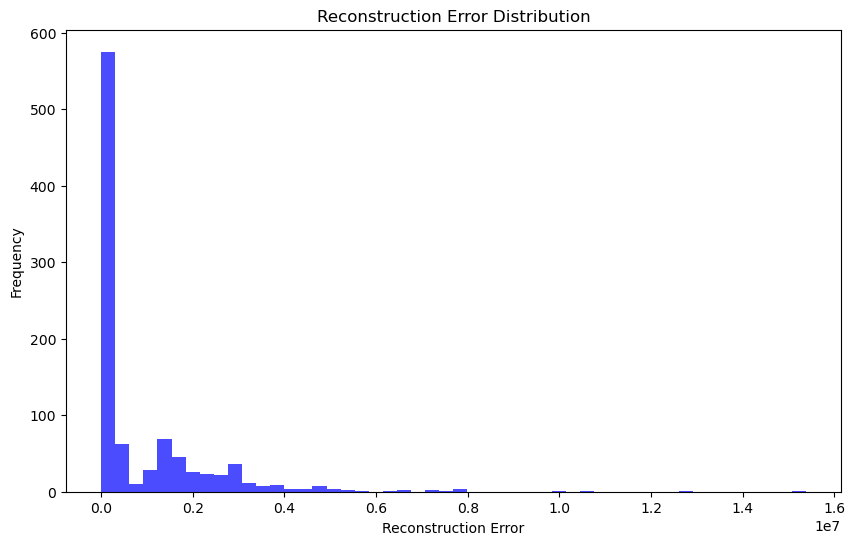

In [18]:
# 테스트 데이터 결합
X_test = np.vstack((X_lying_scaled, X_jumping_scaled))
X_test_reconstructed = autoencoder.predict(X_test)

# 재구성 오차 계산
reconstruction_error = np.mean(np.square(X_test - X_test_reconstructed), axis=1)

# 재구성 오차의 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(reconstruction_error, bins=50, color='blue', alpha=0.7)
plt.title('Reconstruction Error Distribution')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.show()

In [19]:
# 적절한 threshold 설정
threshold = np.mean(reconstruction_error) + 2 * np.std(reconstruction_error)
print(f"Threshold for classification: {threshold}")

Threshold for classification: 3891675.0868694982


In [20]:
# 재구성 오차를 기반으로 분류
predictions = reconstruction_error > threshold  # True: 비정상, False: 정상

In [22]:
# 실제 레이블 생성 (lying: 0, jumping: 1)
y_true = np.array([0] * len(lying_data) + [1] * len(jumping_data))

In [23]:
# 정확도 계산
accuracy = accuracy_score(y_true, predictions)
print(f'Accuracy: {accuracy * 100:.2f}%')

Accuracy: 54.06%


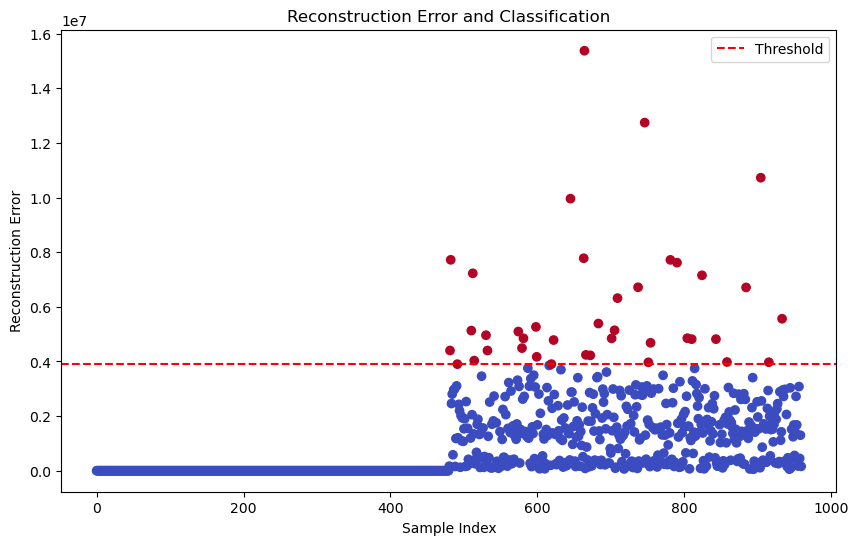

In [24]:
# 결과 시각화
plt.figure(figsize=(10, 6))
plt.scatter(range(len(reconstruction_error)), reconstruction_error, c=predictions, cmap='coolwarm')
plt.axhline(y=threshold, color='r', linestyle='--', label='Threshold')
plt.title('Reconstruction Error and Classification')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.show()